# Part One: Cleaning, Documentation, Assessment of Completeness

This is Part One of a three-part project, intended to demonstrate various skills in the use of Python and the Pandas library for the purposes of data analysis and (to some extent) data science. The dataset we are going to work with is: Armingeon, Klaus, Sarah Engler, Lucas Leemann, and David Weisstanner (2024): Comparative Political Data Set (CPD) 1960–2022. Zurich/Lueneburg/Lucerne: University of Zurich, Leuphana University Lueneburg, and University of Lucerne.

Here, we will perform some basic cleaning, add column descriptions, and assess the completeness of the dataset.

In [1]:
import pandas as pd
import urllib.request
import matplotlib.pyplot as plt

df_original = pd.read_excel("https://cpds-data.org/wp-content/uploads/2024/11/cpds-1960-2022-update-2024-2.xlsx")

print(df_original.shape)
df_original.sample(5)

(1866, 335)


,year,country,countryn,iso,iso3n,cpds1,poco,eu,emu,gov_right1,...,emprot_temp,prefisc_gini,pretran_gini,postfisc_gini,pop,pop15_64,pop65,elderly,year_13,country_13
664,2016,Germany,13,DEU,276,1,0.0,1.0,1.0,0.000000,...,1.125,42.5,39.6,30.1,82349.0,53978.9,17404.9,21.135533,2016,Germany
1021,1995,Latvia,20,LVA,428,0,1.0,0.0,0.0,64.040000,...,NaN,NaN,NaN,NaN,2485.1,1633.1,338.1,13.605086,1995,Latvia
1478,1999,Romania,29,ROU,642,0,1.0,0.0,0.0,52.860000,...,NaN,NaN,NaN,NaN,22458.0,15324.4,2937.0,13.077745,1999,Romania
948,2015,Italy,18,ITA,380,1,0.0,1.0,1.0,0.580177,...,1.625,NaN,NaN,NaN,60229.6,39103.7,13294.4,22.072868,2015,Italy
335,2003,Cyprus,7,CYP,196,0,0.0,0.0,0.0,43.930000,...,NaN,NaN,NaN,NaN,718.3,484.6,85.1,11.847418,2003,Cyprus


## Basic Cleaning and Documentation

In [2]:
df_original[["year", "year_01", "year_13", "country", "country_01", "country_13"]].head(5)

,year,year_01,year_13,country,country_01,country_13
0,1960,1960,1960,Australia,Australia,Australia
1,1961,1961,1961,Australia,Australia,Australia
2,1962,1962,1962,Australia,Australia,Australia
3,1963,1963,1963,Australia,Australia,Australia
4,1964,1964,1964,Australia,Australia,Australia


The dataset contains the columns "year_01" through "year_13" and "country_01" through "country_13", all of which have values identical to those of the columns "year" and "country," respectively. This is likely intended for overview purposes when working with Excel and is not needed here.

In [3]:
redundant_year_columns = [column for column in df_original.columns if column.startswith('year_')]
redundant_country_columns = [column for column in df_original.columns if column.startswith('country_')]
redundant_columns = redundant_year_columns + redundant_country_columns

df_new = df_original.drop(redundant_columns, axis=1)
df_new.shape

(1866, 309)

The CPD dataset comes with a codebook explaining the entries for each column. We will download the PDF and create a codebook.py file. The latter will mainly consist of a dictionary with column names as keys and (sometimes abbreviated, sometimes slightly expanded) descriptions of the columns as values. Codebook entries that (in all likelihood) won't be utilized in subsequent projects are omitted. The keys of the shortened codebook will be used to create a shortened version of the DataFrame, containing only columns potentially relevant for subsequent projects. The codebook.py file will also contain the definition of a CodeBook class, which makes it possible to quickly access the descriptions of columns.

In [4]:
urllib.request.urlretrieve("https://cpds-data.org/wp-content/uploads/2024/11/codebook_cpds.pdf", "bin/codebook.pdf")

('codebook.pdf', <http.client.HTTPMessage at 0x206e60002f0>)

In [37]:
from codebook import CodeBook, codebook_dict

code = CodeBook(codebook_dict)

code.emp_ag

'Civilian employment in agriculture, in thousands'

In [6]:
df_cpd = df_new[df_new.columns.intersection(codebook_dict)].copy()
print(df_cpd.shape)
df_cpd.sample(5)

(1866, 113)


,year,country,poco,eu,emu,gov_right1,gov_cent1,gov_left1,gov_party,gov_new,...,earretir_pmp,emprot_reg,emprot_temp,prefisc_gini,pretran_gini,postfisc_gini,pop,pop15_64,pop65,elderly
702,1991,Greece,0.0,1.0,0.0,100.00,0.00,0.00,1.0,1.0,...,NaN,3.134,4.750,NaN,NaN,NaN,10319.9,6930.7,1443.3,13.985601
179,2013,Belgium,0.0,1.0,1.0,38.46,23.08,38.46,3.0,0.0,...,0.412,1.686,2.250,41.9,40.1,26.2,11159.4,7286.6,1976.8,17.714214
866,1996,Ireland,0.0,1.0,0.0,0.00,53.33,46.67,3.0,0.0,...,NaN,1.269,0.250,45.1,45.2,32.6,3626.1,2366.3,414.5,11.431014
427,1999,Denmark,0.0,1.0,0.0,20.00,0.00,80.00,4.0,0.0,...,1.703,1.468,1.375,NaN,NaN,NaN,5321.0,3557.0,790.4,14.854351
1445,1999,Portugal,0.0,1.0,1.0,0.00,0.00,84.80,4.0,0.0,...,NaN,4.583,2.812,NaN,NaN,NaN,10217.8,6894.3,1628.1,15.933958


CPD contains almost 170 columns tracking exclusively vote and seat shares of political parties. We will create a separate codebook and dataframe for these columns.

In [7]:
from codebook import create_shares_dict

party_shares_list = df_new.loc[:,"social1": "sothers"].columns.tolist()
party_shares_dict = create_shares_dict(party_shares_list)

party = CodeBook(party_shares_dict)

party.allia2, party.spension1

('Share of votes of the party classified as ‘allia2’. The superordinate party family is classified as ‘Electoral Alliance’',
 'Share of seats of the party classified as ‘spension1’. The superordinate party family is classified as ‘Pensioners’')

In [8]:
df_parties = pd.concat([df_new.loc[:, ["year", "country"]].copy(), df_new[df_new.columns.intersection(party_shares_dict)].copy()], axis=1)
print(df_parties.shape)
df_parties.sample(5)

(1866, 170)


,year,country,social1,social2,social3,social4,social5,social6,social7,social8,...,smonarch1,sperson1,spension1,spension2,snonlbl1,snonlbl2,sallia1,sallia2,sallia3,sothers
1025,1999,Latvia,0.0,0.0,14.2,0.0,12.9,7.3,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1774,1994,United Kingdom,34.9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.7
1273,1970,New Zealand,44.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
803,1996,Iceland,11.4,0.0,7.1,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1422,1976,Portugal,36.7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.3


## Assessing Completeness

If there are certain countries or columns with especially low numbers of observations, some kinds of potential future inquiries might have to be limited in scope or may not be possible at all. It will be useful to get an overview of this ahead of time.

### Completeness by Country

In [26]:
countries_obs_count = df_new.groupby("country")[df_new.columns].count().sum(axis="columns").sort_values()
countries_obs_count

country
Croatia            5891
Latvia             8198
Bulgaria           8383
Estonia            8428
Lithuania          8457
Romania            8543
Slovenia           8771
Poland             9030
Hungary            9078
Slovakia           9085
Czech Republic     9210
Cyprus            11543
Spain             13129
Portugal          13283
Malta             13982
Greece            15344
Iceland           16348
Luxembourg        16637
Switzerland       17028
New Zealand       17038
Austria           17122
Australia         17127
Norway            17173
Belgium           17204
Denmark           17209
Netherlands       17252
Italy             17282
Ireland           17291
France            17300
Japan             17315
Germany           17328
Sweden            17336
Finland           17344
USA               17384
United Kingdom    17391
Canada            17437
dtype: int64

When comparing observation counts per country, it is hard to overlook the fact that the 11 countries with the lowest counts all appear to be post-communist countries. Keeping in mind that the earliest entries in the dataset are from the year 1960, let's check which year is associated with the earliest entry for each country.

In [10]:
df_new.groupby("country")["year"].first().sort_values(ascending=False)

country
Croatia           2000
Latvia            1993
Estonia           1992
Lithuania         1992
Poland            1991
Hungary           1990
Romania           1990
Slovakia          1990
Slovenia          1990
Czech Republic    1990
Bulgaria          1990
Spain             1977
Cyprus            1976
Portugal          1975
Malta             1966
Norway            1960
New Zealand       1960
Australia         1960
Sweden            1960
Switzerland       1960
USA               1960
Netherlands       1960
Japan             1960
Luxembourg        1960
Austria           1960
Italy             1960
Ireland           1960
Iceland           1960
Greece            1960
Germany           1960
France            1960
Finland           1960
Denmark           1960
Canada            1960
Belgium           1960
United Kingdom    1960
Name: year, dtype: int64

The earliest year of entry into the dataset for 10 out of the 11 countries with the lowest observation counts is between 1990 and 1993, and 2000 for the remaining country (Croatia). After quickly confirming that these are indeed the countries marked as post-communist via the poco column, we will compare observation counts per country from 1993 onward, excluding Croatia.

In [25]:
code.poco

'Dummy variable with value 1 for post-communist countries'

In [11]:
post_communist_countries = df_new[df_new["poco"]==1]["country"].unique().tolist()
len(post_communist_countries)

11

In [12]:
countries_most_nan = sorted(countries_obs_count.head(11).index.tolist())
post_communist_countries == countries_most_nan

True

In [27]:
df_new[df_new["year"] >= 1993].groupby("country")[df_new.columns].count().sum(axis="columns").sort_values()

country
Croatia           5891
Bulgaria          7722
Cyprus            7847
Romania           7879
Malta             7934
Slovenia          8155
Latvia            8198
Estonia           8199
Lithuania         8234
Iceland           8318
Hungary           8358
Greece            8416
Slovakia          8424
Luxembourg        8439
Portugal          8476
Czech Republic    8480
Poland            8512
Australia         8517
Switzerland       8549
New Zealand       8553
Netherlands       8574
Japan             8582
Italy             8588
Belgium           8599
Norway            8607
Finland           8607
USA               8610
Denmark           8619
United Kingdom    8631
Austria           8634
France            8648
Ireland           8651
Sweden            8660
Canada            8665
Spain             8685
Germany           8690
dtype: int64

Even when only looking at dataset entries from 1993 onwards (excluding Croatia), most of the countries with the 10 lowest observation counts are post-communist countries, implying a comparatively high number of NaN values. There might, however, still be a trend toward greater completeness over time. We will test this by separating the data from 1993 onwards into three time segments and calculating the differences in observation count between the country with the highest and the second-lowest counts for each.

In [28]:
countries_obs_count_1991_to_2001 = df_new[df_new["year"].between(1993, 2001)].groupby("country")[df_new.columns].count().sum(axis="columns").sort_values()
countries_obs_count_2001_to_2011 = df_new[df_new["year"].between(2002, 2011)].groupby("country")[df_new.columns].count().sum(axis="columns").sort_values()
countries_obs_count_2011_to_2022 = df_new[df_new["year"].between(2012, 2022)].groupby("country")[df_new.columns].count().sum(axis="columns").sort_values()

print(countries_obs_count_1991_to_2001.iloc[-1] - countries_obs_count_1991_to_2001.iloc[1])
print(countries_obs_count_2001_to_2011.iloc[-1] - countries_obs_count_2001_to_2011.iloc[1])
print(countries_obs_count_2011_to_2022.iloc[-1] - countries_obs_count_2011_to_2022.iloc[1])

487
294
212


The gap between countries with the highest and lowest observation counts appears to be shrinking over time, suggesting improved availability of data on post-communist countries. We should be able to see this more clearly by plotting both the average observation counts for post-communist countries and the observation counts for the country with the highest count (the United Kingdom) over time.

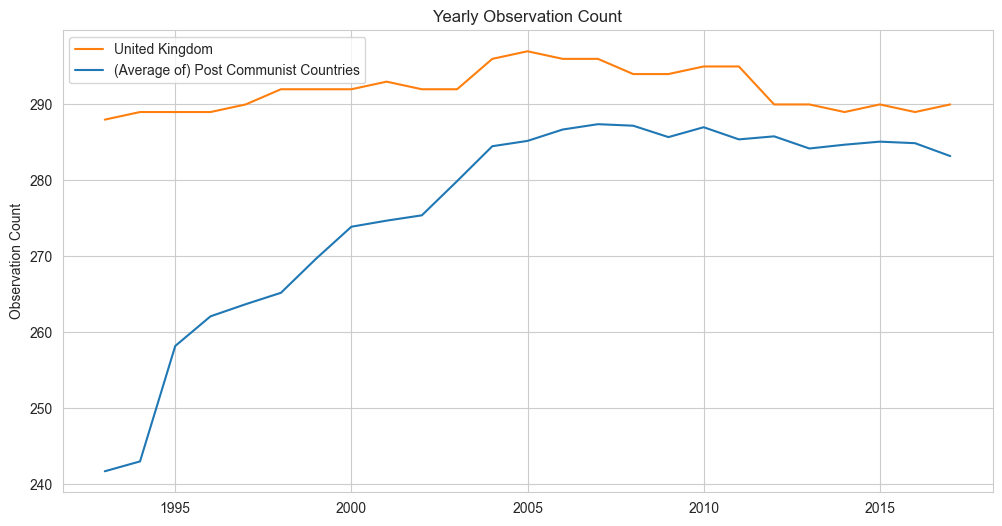

In [14]:
df_observation_count = df_new.groupby(["country", "year"])[df_new.columns].count().sum(axis="columns").reset_index(name="count")
df_observation_count = df_observation_count.pivot(index="year", columns="country", values="count")

pcc = post_communist_countries.copy()
pcc.remove("Croatia")

df_observation_count = (df_observation_count[pcc].mean(axis=1).loc[1993:2017].to_frame(name="(Average of) Post Communist Countries")
                        .join(df_observation_count["United Kingdom"].loc[1993:2017]))

df_observation_count.plot(kind="line", figsize=(12, 6))
plt.title("Yearly Observation Count")
plt.xlabel("")
plt.ylabel("Observation Count")
plt.legend(reverse=True)
plt.savefig("figures/(01)_yearly_observation_count.png")
plt.show()

### Completeness by Column

Let's get an overview of which columns have the highest numbers of missing entries, see if they are the same when post-communist countries are excluded, and look at some of the columns' descriptions for possible explanations.

In [33]:
df_new.isna().sum().sort_values(ascending=False)

leff       1821
lbank      1821
lrid       1821
lbic       1821
lfed       1821
           ... 
iso           0
country       0
iso3n         0
cpds1         0
year          0
Length: 309, dtype: int64

In [34]:
df_new[df_cpd["poco"]==0].isna().sum().sort_values(ascending=False)

ldis          1470
ljud          1470
lfirst        1470
lsec          1470
leff          1470
              ... 
sright6          0
country          0
sconserv9        0
sconserv13       0
year             0
Length: 309, dtype: int64

In [36]:
code.leff

'Effective number of parliamentary parties'

In [17]:
code.elect

'Date of election of national parliament (lower house). (If there were two elections in a year, the date of the second is given)'

In [18]:
code.prefisc_gini

"Gini index of pre-fisc income (before taxes and transfers) among household members aged 18-65, in percent. [...] Data available in survey waves every few years. ['The Gini index measures the extent to which the distribution of income or consumption among individuals or households within an economy deviates from a perfectly equal distribution. A Gini index of 0 represents perfect equality, while an index of 100 implies perfect inequality.' Definition according to the databank.worldbank.org Metadata Glossary]"

In [19]:
code.educatt_minimal, code.educatt_tertiary

('Share of population attending no more than secondary education',
 'Share of population attending tertiary education')

In the case of the column elect and columns referencing the Gini index, a large number of missing entries is to be expected, since they aren't intended to contain yearly entries. For the education- and institution-related variables (the latter are tracked in columns starting with l), there might be issues regarding the consistent availability of data. We will keep this in mind for subsequent parts of the project.